# Proyek Klasifikasi Gambar: Flower Classification
- **Nama:** Dwi Cahya Nurani
- **Email:** dcnurani03@gmail.com
- **ID Dicoding:** MC008D5X2344

## Import Semua Packages/Library yang Digunakan

In [3]:
# Library umum
import os, shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tq
import random

# Library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library preprocessing gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Library modeling
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Large
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# Library konversi model
import tensorflowjs as tfjs
import pathlib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

https://www.kaggle.com/datasets/marquis03/flower-classification

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d marquis03/flower-classification
!unzip flower-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/iris/17858672081_4b4d071116_c.jpg  
  inflating: train/iris/17885928250_451875aec2_c.jpg  
  inflating: train/iris/17948299355_2161a031db_c.jpg  
  inflating: train/iris/17959086836_3e706d918b_c.jpg  
  inflating: train/iris/18054931376_23052f68d0_c.jpg  
  inflating: train/iris/18059533553_186ccb451a_c.jpg  
  inflating: train/iris/18076633321_400ea17b5a_c.jpg  
  inflating: train/iris/18120244292_ea11fcc9c5_c.jpg  
  inflating: train/iris/181379030_afebe26851_c.jpg  
  inflating: train/iris/18141122602_118114762d_c.jpg  
  inflating: train/iris/18256508742_af6a8f4222_c.jpg  
  inflating: train/iris/18280071332_c6bc90d75a_c.jpg  
  inflating: train/iris/18348714266_33a7bf205f_c.jpg  
  inflating: train/iris/18504796248_9548f45757_c.jpg  
  inflating: train/iris/18519018712_9ae5d4be08_c.jpg  
  inflating: train/iris/18551525352_70323e50e0_c.jpg  
  inflating: train/iris/18607022104_4ae51cd825_c.jpg  
  inflating: tra

In [6]:
# Direktori data awal
train_dir = "train/"
val_dir = "val/"

# Direktori baru untuk dataset gabungan
combined_dir = "dataset/"
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk menyalin gambar dan memberi nama dengan urutan angka
def copy_files_with_sequential_names(source_dir, destination_dir, start_index):
    current_index = start_index
    for category in os.listdir(source_dir):
        category_dir = os.path.join(source_dir, category)
        if os.path.isdir(category_dir):
            dest_category_dir = os.path.join(destination_dir, category)
            os.makedirs(dest_category_dir, exist_ok=True)

            for file_name in os.listdir(category_dir):
                file_path = os.path.join(category_dir, file_name)
                if os.path.isfile(file_path):
                    # Buat nama file baru dengan urutan angka
                    new_file_name = f"{current_index}.jpg"
                    dest_file_path = os.path.join(dest_category_dir, new_file_name)
                    shutil.copy(file_path, dest_file_path)
                    current_index += 1

    return current_index

# Salin file dan folder dari training, lanjutkan urutan angka
start_index = 0
start_index = copy_files_with_sequential_names(train_dir, combined_dir, start_index)

# Salin file dan folder dari validation, lanjutkan urutan angka
start_index = copy_files_with_sequential_names(val_dir, combined_dir, start_index)

**Data Visualization**

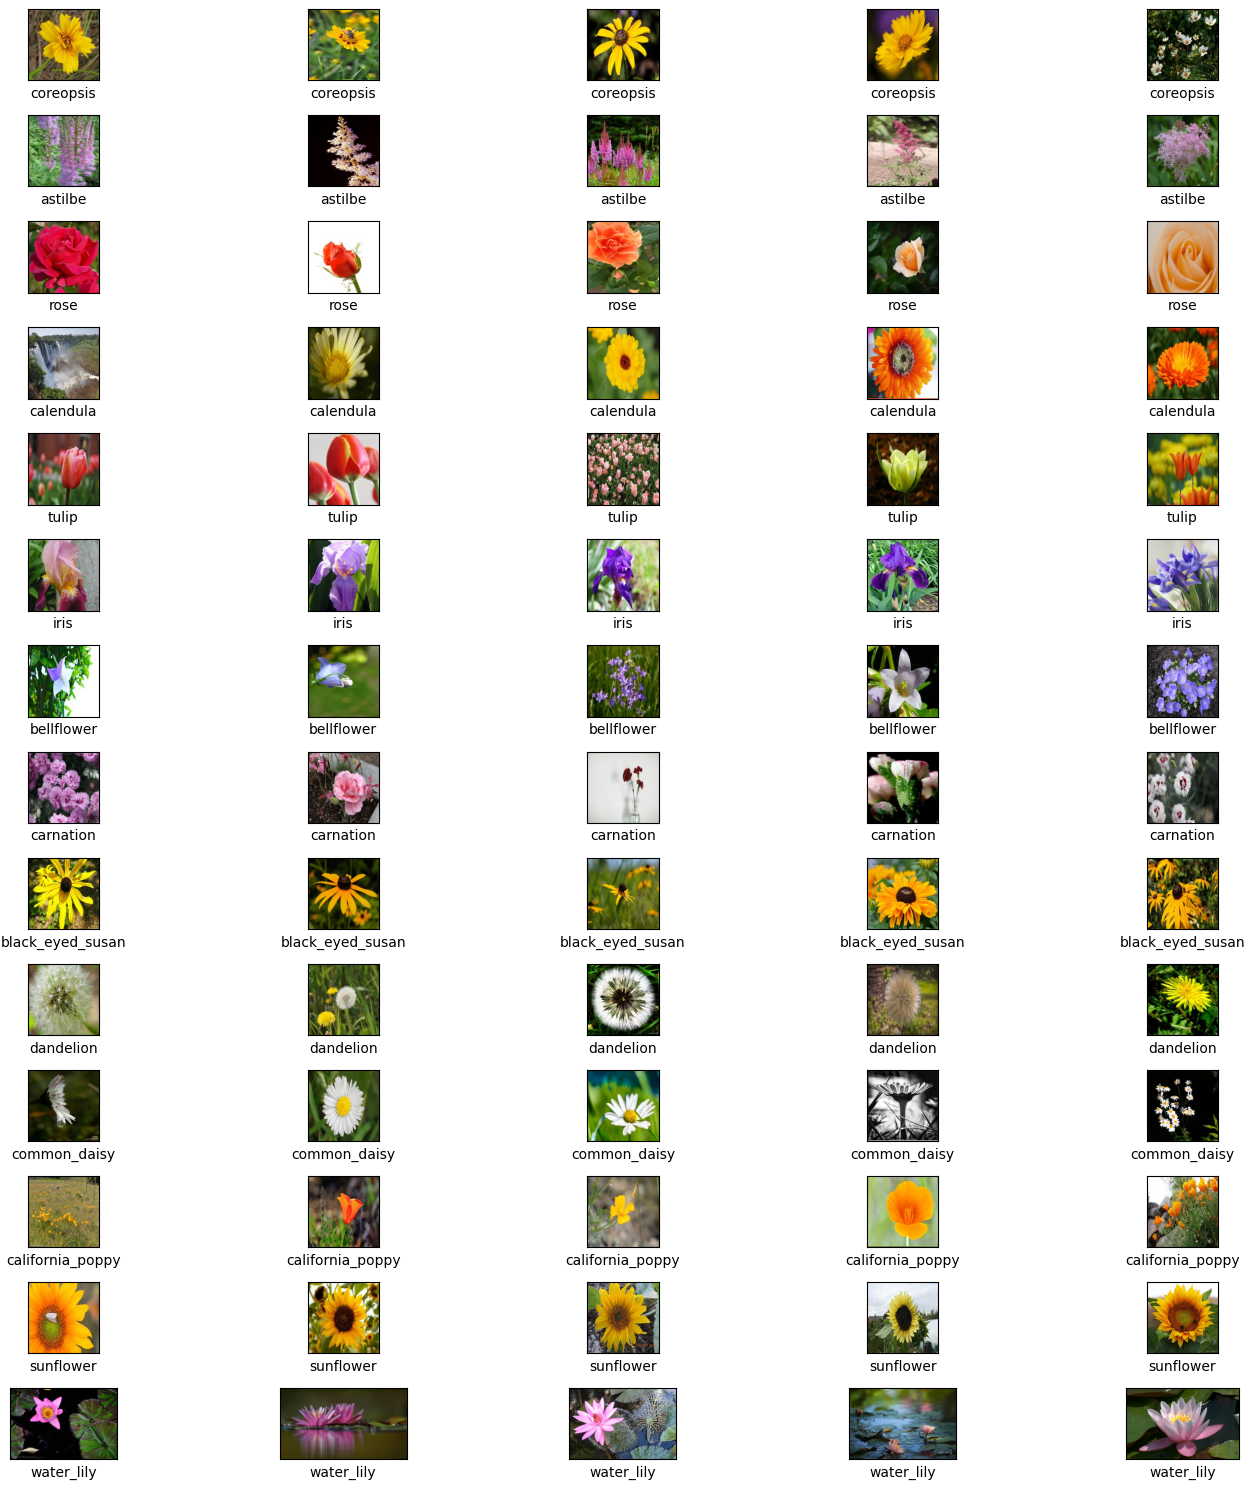

In [7]:
# Direktori dataset
path = "dataset/"
flower_image = {}

# Memasukkan nama kelas dan daftar gambar pada setiap kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        flower_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar untuk setiap kelas
fig, axs = plt.subplots(len(flower_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(flower_image.keys()):
    images = np.random.choice(flower_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

In [20]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

path = "dataset/"
print_images_resolution(path)

coreopsis: 1042
- (256, 256)
---------------
astilbe: 733
- (256, 256)
---------------
rose: 993
- (256, 256)
---------------
calendula: 1018
- (256, 256)
---------------
tulip: 1041
- (256, 256)
---------------
iris: 1048
- (256, 256)
---------------
bellflower: 879
- (256, 256)
---------------
carnation: 931
- (256, 256)
---------------
black_eyed_susan: 993
- (256, 256)
---------------
dandelion: 1045
- (256, 256)
---------------
common_daisy: 985
- (256, 256)
---------------
california_poppy: 1028
- (256, 256)
---------------
sunflower: 1020
- (256, 256)
---------------
water_lily: 984
- (799, 484)
- (800, 791)
- (799, 548)
- (799, 438)
- (799, 502)
- (800, 501)
- (800, 620)
- (799, 630)
- (800, 400)
- (800, 519)
- (800, 638)
- (800, 702)
- (800, 528)
- (800, 647)
- (800, 711)
- (800, 656)
- (799, 239)
- (799, 532)
- (799, 541)
- (531, 800)
- (799, 550)
- (750, 600)
- (800, 549)
- (799, 614)
- (799, 495)
- (799, 559)
- (800, 558)
- (800, 677)
- (571, 799)
- (800, 567)
- (800, 448)


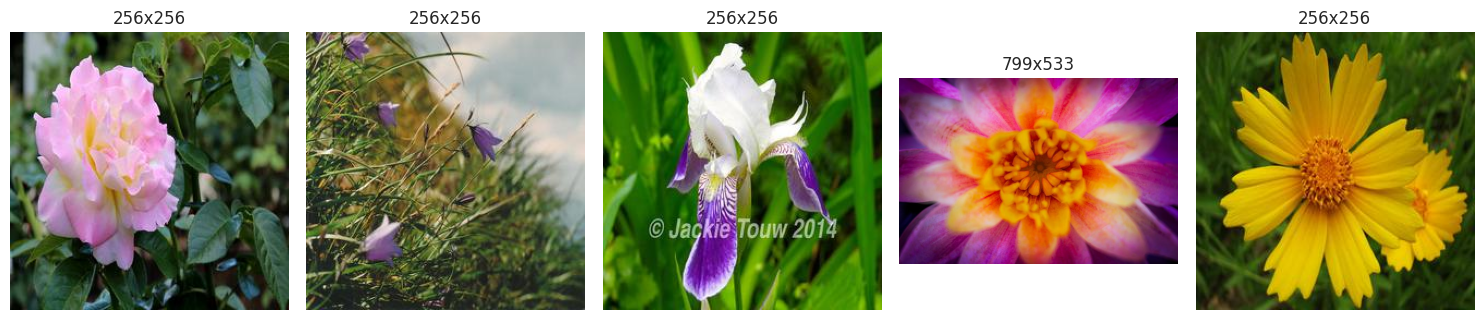

In [17]:
path = "dataset/"
image_paths = []

for path, subdirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(path, file)

        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(file_path)

# Pilih 5 gambar acak dari dataset
random_images = random.sample(image_paths, 5)

# Menampilkan 5 gambar acak dengan resolusi
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    width, height = img.size

    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'{width}x{height}')  # Tampilkan resolusi di atas gambar

plt.tight_layout()
plt.show()

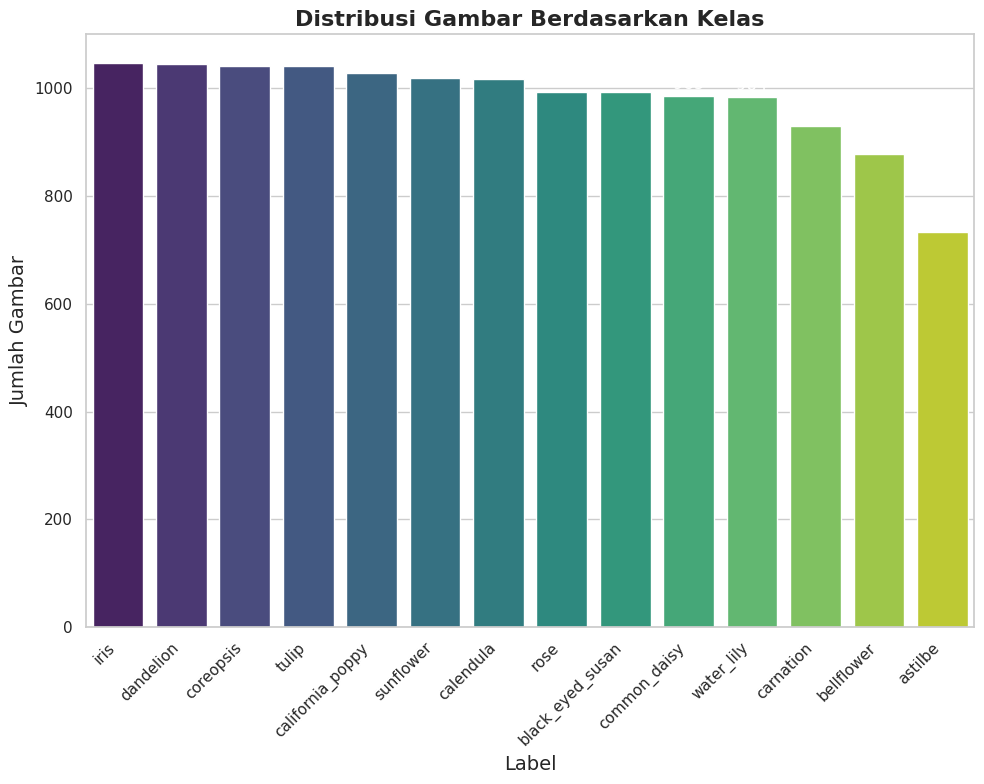

In [9]:
path = "dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"Path": full_path, 'File_Name': file_name, "Label": labels})

# Hitung jumlah gambar pada tiap label dan uruktan dari yang paling banyak
label_counts = distribution_train['Label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

distribution_train_sorted = distribution_train.set_index('Label').loc[label_counts['Label']].reset_index()

# Plot distribusi
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
plot_data = sns.countplot(data=distribution_train_sorted, x='Label', palette='viridis')

for p in plot_data.patches:
    plot_data.annotate(format(p.get_height(), '.0f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       fontsize=12, color='white',
                       xytext=(0, 9), textcoords='offset points')

plt.title('Distribusi Gambar Berdasarkan Kelas', fontsize=16, weight='bold')
plt.xlabel('Label', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [10]:
data_path= 'dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(data_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


df = pd.DataFrame({"Path":full_path,'File_Name':file_name,"Label":labels})
df.groupby(['Label']).size()

,0
Label,
astilbe,733
bellflower,879
black_eyed_susan,993
calendula,1018
california_poppy,1028
carnation,931
common_daisy,985
coreopsis,1042
dandelion,1045


In [11]:
X= df['Path']
y= df['Label']

# Split dataset awal menjadi data train (80%) dan test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
df_tr = pd.DataFrame({'Path':X_train, 'Label':y_train, 'Set':'train'})
df_te = pd.DataFrame({'Path':X_test, 'Label':y_test, 'Set':'test'})

print('Train Size:', len(df_tr))
print('Test Size', len(df_te))

Train Size: 10992
Test Size 2748


In [13]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)
df_all.groupby(['Set', 'Label']).size()

Set    Label           
test   astilbe             143
       bellflower          183
       black_eyed_susan    187
       calendula           190
       california_poppy    221
       carnation           180
       common_daisy        215
       coreopsis           193
       dandelion           226
       iris                214
       rose                180
       sunflower           205
       tulip               211
       water_lily          200
train  astilbe             590
       bellflower          696
       black_eyed_susan    806
       calendula           828
       california_poppy    807
       carnation           751
       common_daisy        770
       coreopsis           849
       dandelion           819
       iris                834
       rose                813
       sunflower           815
       tulip               830
       water_lily          784
dtype: int64

In [14]:
data_path = "dataset/"
final_path = "dataset_final/"

In [15]:
for index, row in tq(df_all.iterrows()):
    file_path = row['Path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(data_path, row['Label'], row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(final_path, row['Set'], row['Label'])) == False:
        os.makedirs(os.path.join(final_path, row['Set'],row['Label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(final_path, row['Set'], row['Label'], destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

**Image Data Generator**

In [16]:
# Direktori data
train_dir = "dataset_final/train/"
test_dir = "dataset_final/test/"

# Normalisasi gambar dengan ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(224,224),
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(train_dir,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  shuffle=False)

Found 8799 images belonging to 14 classes.
Found 2193 images belonging to 14 classes.
Found 2748 images belonging to 14 classes.


Tidak dilakukan augmentasi data karena dataset sudah cukup besar dan bervariasi, serta jumlah gambar di setiap kelas tidak berbeda jauh.

## Modelling

**Skema 1: Model CNN Architecture**

In [21]:
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(14, activation='softmax')
])

model1.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │     5,519,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,520,718 (21.06 MB)

 Trainable params: 5,520,718 (21.06 MB)

 Non-trainable params: 0 (0.00 B)

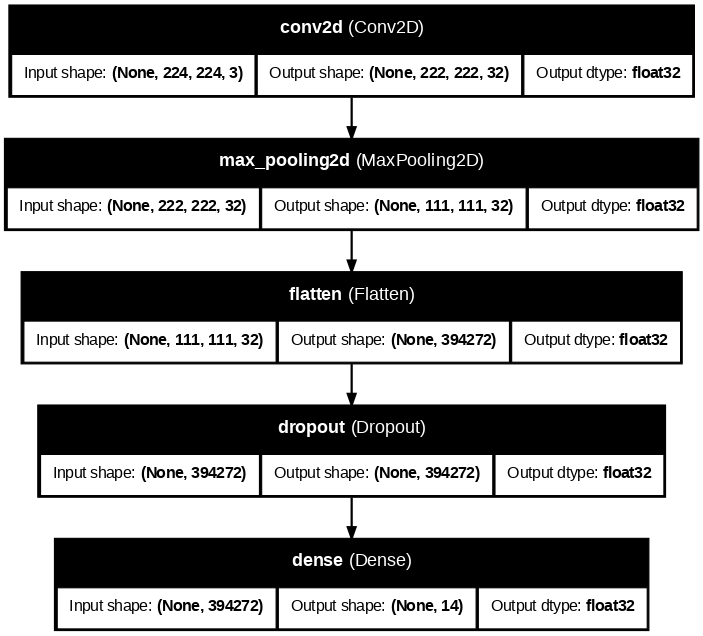

In [22]:
tf.keras.utils.plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

In [23]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:
history1 = model1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=early_stopping)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.3314 - loss: 3.1362 - val_accuracy: 0.5025 - val_loss: 1.4936
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.7203 - loss: 0.9429 - val_accuracy: 0.5860 - val_loss: 1.3576
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.8939 - loss: 0.4014 - val_accuracy: 0.5910 - val_loss: 1.3669
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9681 - loss: 0.1628 - val_accuracy: 0.5887 - val_loss: 1.4659
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.9856 - loss: 0.0832 - val_accuracy: 0.5709 - val_loss: 1.6851
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9895 - loss: 0.0606 - val_accuracy: 0.5663 - val_loss: 1.8493
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9891 - loss: 0.0658 - val_accuracy: 0.5860 - val_loss: 1.8056
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9963 - loss: 0.0235 - val_accurac

In [25]:
final_train_acc = history1.history['accuracy'][-1]
final_val_acc = history1.history['val_accuracy'][-1]

print(f"Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy: {final_val_acc * 100:.2f}%")

Training Accuracy: 99.00%
Validation Accuracy: 53.67%


Berdasarkan hasil akurasi pada data train dan validation, terindikasi adanya overfitting.

**Skema 2: Using Pre-Trained Model (MobileNet) & SGD Optimizer**

Telah dicoba menggunakan beberapa kombinasi Optimizer, tetapi hasil SGD Optimizer paling baik.

In [26]:
# Membangun model dengan MobileNet
base_model = MobileNet(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model2 = Sequential([
    base_model,
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(64, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(14, activation='softmax')
])

model2.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,567,150 (13.61 MB)

 Trainable params: 338,094 (1.29 MB)

 Non-trainable params: 3,229,056 (12.32 MB)

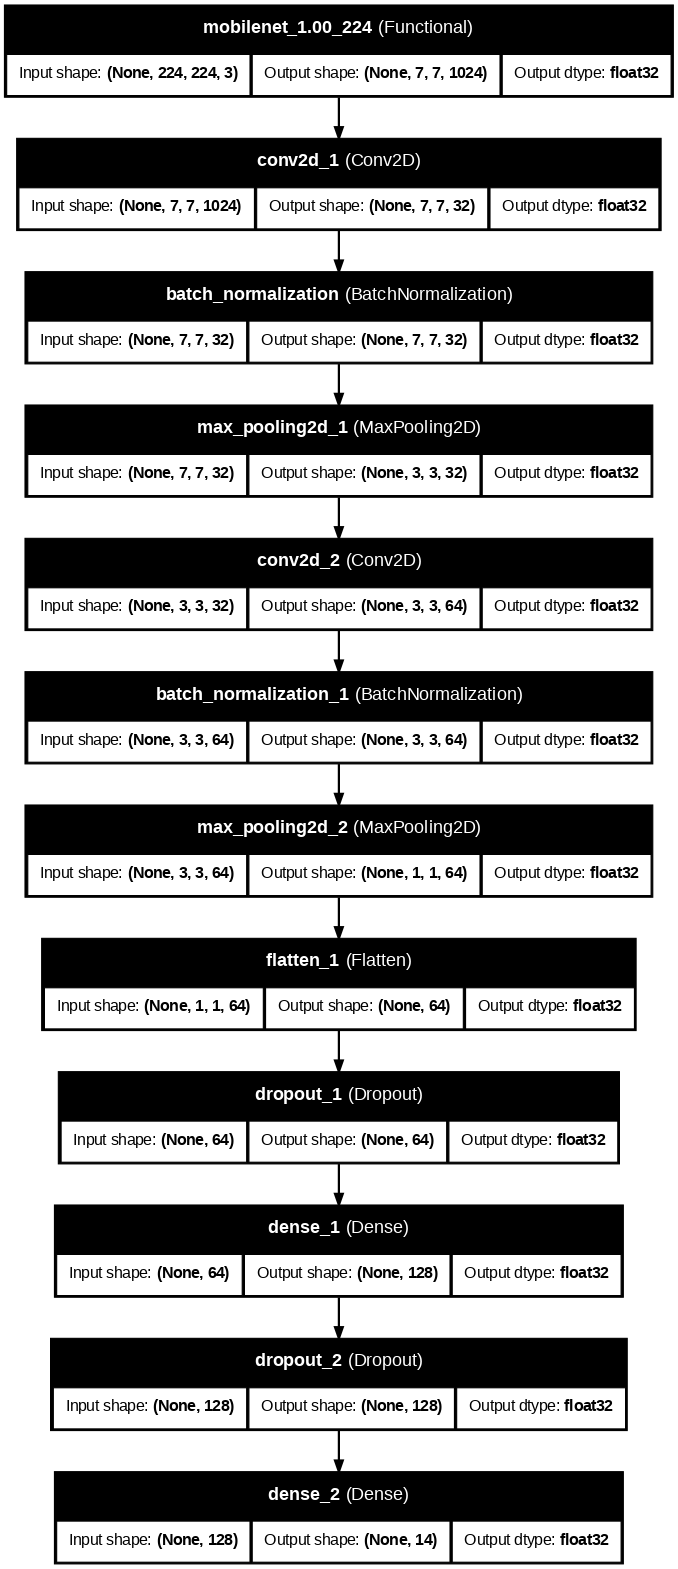

In [27]:
tf.keras.utils.plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

In [28]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
history2 = model2.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=early_stopping)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.2179 - loss: 2.9538 - val_accuracy: 0.7756 - val_loss: 0.9482
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.5442 - loss: 1.4162 - val_accuracy: 0.8345 - val_loss: 0.6001
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6707 - loss: 1.0228 - val_accuracy: 0.8787 - val_loss: 0.4603
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.7449 - loss: 0.7862 - val_accuracy: 0.8892 - val_loss: 0.3930
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.7874 - loss: 0.6506 - val_accuracy: 0.8833 - val_loss: 0.4065
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.8180 - loss: 0.5800 - val_accuracy: 0.8865 - val_loss: 0.3728
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.8454 - loss: 0.4901 - val_accuracy: 0.8938 - val_loss: 0.3669
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.8583 - loss: 0.4528 -

In [30]:
final_train_acc = history2.history['accuracy'][-1]
final_val_acc = history2.history['val_accuracy'][-1]

print(f"Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy: {final_val_acc * 100:.2f}%")

Training Accuracy: 96.65%
Validation Accuracy: 90.20%


**Skema 3: Using Pre-Trained Model (DenseNet121) & SGD Optimizer**

In [31]:
# Membangun model dengan DenseNet121
base_model = DenseNet121(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model3 = Sequential([
    base_model,
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Conv2D(64, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(14, activation='softmax')
])

model3.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 32)       │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,375,790 (28.14 MB)

 Trainable params: 338,094 (1.29 MB)

 Non-trainable params: 7,037,696 (26.85 MB)

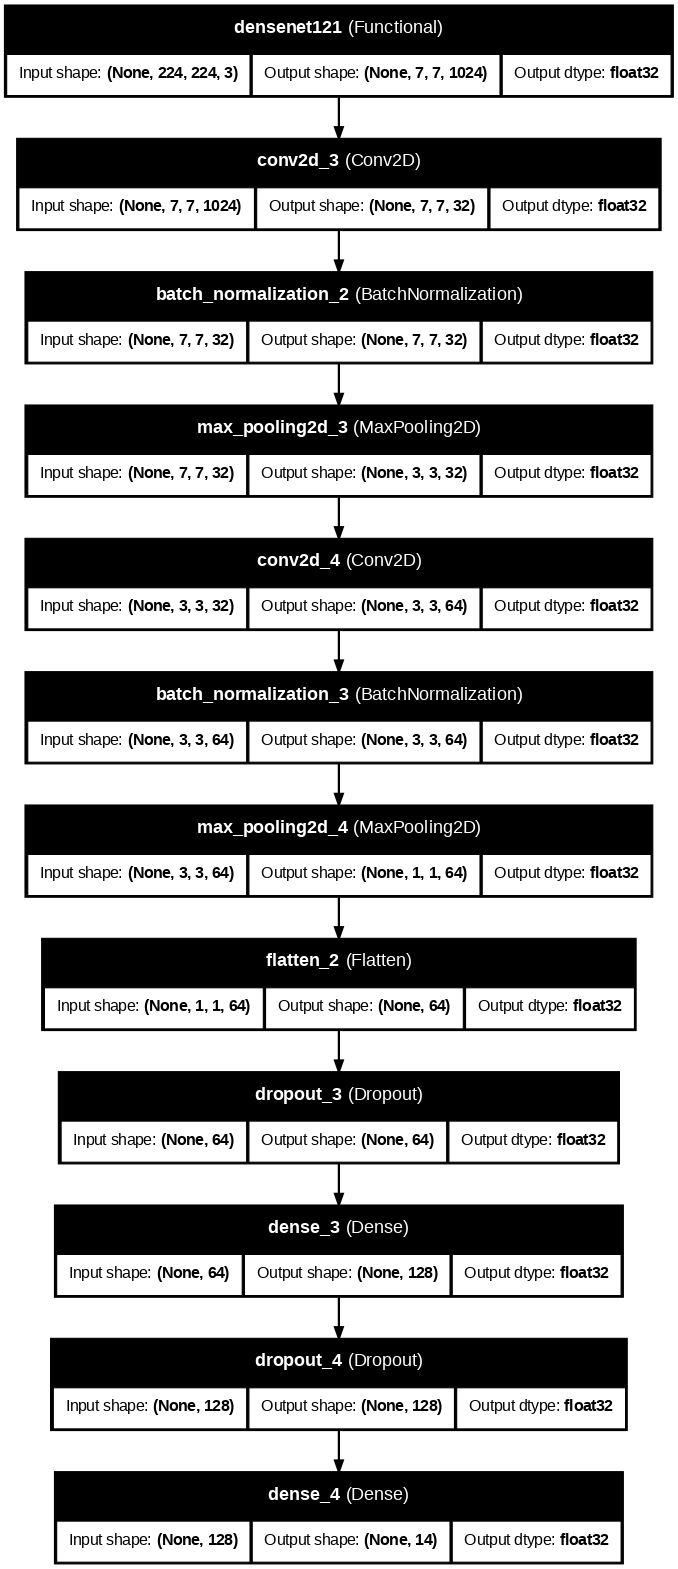

In [32]:
tf.keras.utils.plot_model(model3, to_file='model3.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

In [33]:
# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [34]:
history3 = model3.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        callbacks=early_stopping)

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 121s 318ms/step - accuracy: 0.3810 - loss: 2.1840 - val_accuracy: 0.8381 - val_loss: 0.5275
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.8019 - loss: 0.6438 - val_accuracy: 0.8842 - val_loss: 0.4340
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.8789 - loss: 0.4342 - val_accuracy: 0.8814 - val_loss: 0.4426
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.8916 - loss: 0.3779 - val_accuracy: 0.8874 - val_loss: 0.4344
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.9155 - loss: 0.2949 - val_accuracy: 0.8773 - val_loss: 0.4965
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - accuracy: 0.9220 - loss: 0.2814 - val_accuracy: 0.8910 - val_loss: 0.4327
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.9339 - loss: 0.2205 - val_accuracy: 0.8819 - val_loss: 0.5069
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.9472 - loss: 

In [35]:
final_train_acc = history3.history['accuracy'][-1]
final_val_acc = history3.history['val_accuracy'][-1]

print(f"Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy: {final_val_acc * 100:.2f}%")

Training Accuracy: 97.58%
Validation Accuracy: 89.56%


## Evaluasi dan Visualisasi

In [36]:
# Evaluasi Model 1
test_loss_1, test_acc_1 = model1.evaluate(test_generator)
print(f"Model 1 - Test Accuracy: {test_acc_1 * 100:.2f}%")

# Evaluasi Model 2
test_loss_2, test_acc_2 = model2.evaluate(test_generator)
print(f"Model 2 - Test Accuracy: {test_acc_2 * 100:.2f}%")

# Evaluasi Model 3
test_loss_3, test_acc_3 = model3.evaluate(test_generator)
print(f"Model 3 - Test Accuracy: {test_acc_3 * 100:.2f}%")

# Membandingkan test accuracy
test_accuracies = [test_acc_1, test_acc_2, test_acc_3]
models = ['Model 1', 'Model 2', 'Model 3']

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2748/2748 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5056 - loss: 1.5145
Model 1 - Test Accuracy: 56.44%
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8829 - loss: 0.4545
Model 2 - Test Accuracy: 91.16%
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.8758 - loss: 0.5025
Model 3 - Test Accuracy: 91.08%


Dipilih model 2 karena menghasilkan akurasi paling baik pada data test.

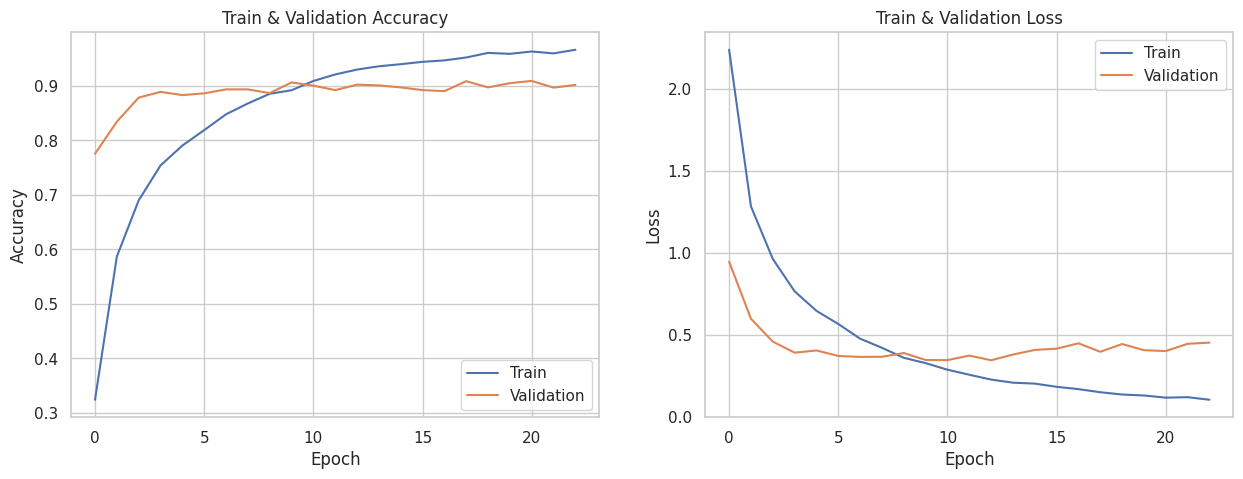

In [37]:
best = history2
epochs = range(len(best.history['accuracy']))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, best.history['accuracy'], label='Train')
plt.plot(epochs, best.history['val_accuracy'], label='Validation')
plt.title('Train & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs, best.history['loss'], label='Train')
plt.plot(epochs, best.history['val_loss'], label='Validation')
plt.title('Train & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

- Training Accuracy menunjukkan peningkatan yang stabil seiring berjalannya waktu, mencapai nilai mendekati 1 (100%) setelah beberapa epoch. Validation Accuracy menunjukkan nilai yang stabil.
- Training Loss menunjukkan penurunan yang tajam pada awalnya, menandakan bahwa model semakin baik dalam mengurangi kesalahan selama pelatihan Validation Loss menurun juga pada awalnya, tetapi setelah itu terhenti atau sedikit meningkat, yang menunjukkan bahwa model mulai overfit.

In [38]:
test_score, test_acc = model2.evaluate(test_generator)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

2748/2748 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8829 - loss: 0.4545
Test Loss = 0.31838884949684143
Test Accuracy = 0.9115720391273499


## Konversi Model

In [39]:
# Menyimpan model ke format SavedModel
save_path = 'saved_model/'
tf.saved_model.save(model2, save_path)

In [40]:
# Menyimpan model ke format TensorFlow.js
model2.save("model.h5")

In [41]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-27 08:57:49.435982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745744269.458456   10817 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745744269.465090   10817 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [48]:
# Mengonversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

## Inference (Optional)

In [43]:
# Muat model SavedModel
saved_model = tf.keras.models.load_model('model.h5')

# Gambar baru yang ingin diprediksi
img_path = '/content/dataset_final/test/iris/13680.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Normalisasi gambar
img_array /= 255.0

# Lakukan prediksi
predictions = saved_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Nama label
class_names = ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation',
       'common_daisy', 'coreopsis', 'dandelion', 'iris',
       'rose', 'sunflower', 'tulip', 'water_lily']

# Mengonversi indeks kelas ke nama label
predicted_label = class_names[predicted_class[0]]
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: iris
